In [175]:
"""
All libraries
"""
import matplotlib.pyplot as plt
import numpy as np
from snn_dpe.tools.network import create_encoders,create_network,load_trained_network,save_trained_network
from snn_dpe.tools.train import forward_pass, mse, update_weights
from tqdm import tqdm
from snn_dpe.tools.plotting import *
import pandas as pd

def generate_io_pairs(timeseries_data, input_window_size, output_window_size, stride = 1):
    
    TS_inputs, TS_outputs = [], []
    for start_idx in range(0, len(timeseries_data) - input_window_size - output_window_size, stride):
        input_i = timeseries_data[start_idx:start_idx+input_window_size]
        output_i = timeseries_data[start_idx+input_window_size:start_idx+input_window_size+output_window_size]
        TS_inputs.append(input_i)
        TS_outputs.append(output_i)
    return np.asarray(TS_inputs),np.asarray(TS_outputs)


class Reservior_DPE_training:
    
    def __init__(self,neurons, n_input,plot=True):
        self.neurons=neurons
        self.n_input=n_input
        self.plot=plot
    
    def run_network_timeseries(self,data):
        # simulate
        self.data=data
        spike_raster = []
        for i in range(len(self.data)):
            spike_raster.append([])

        # feed a peice of data in at each timestep
        for t in range(len(self.data)):
            # get the input for this timestep, and apply it to input neurons
            for i in range(int(self.n_input/2)): #normal
                self.neurons[i].apply_potential(self.data[t])
            for i in range(int(self.n_input/2)): #inverted
                self.neurons[i+int(self.n_input/2)].apply_potential(-self.data[t]+1)

            # update the network
            for n in self.neurons:
                if n.update():
                    spike_raster[t].append(1)
                else:
                    spike_raster[t].append(0)

        self.spike_raster=np.asarray(spike_raster)

    def train_TS(self, TS_inputs, TS_outputs, initial_weights = None, initial_bias = None, relative=False, n_epochs=3):
        
        self.TS_inputs=TS_inputs
        self.TS_outputs=TS_outputs
        self.initial_weights=initial_weights
        
        if self.initial_weights == None:
            dpe_weights = np.random.rand(len(self.neurons), len(self.TS_outputs[0]))
            dpe_bias = np.random.rand(len(self.TS_outputs[0]))
        else:
            dpe_weights = self.initial_weights
            dpe_bias = self.initial_bias
        epoch_mses = [] 
        for _ in range(n_epochs):
            # iterate over the data in steps of input_window_size while avoiding out of bounds error
            pbar = tqdm(self.TS_inputs)
            mse_avg = 0
            n_processed = 0
            for input_i, output_i in zip(pbar, self.TS_outputs):
                self.run_network_timeseries(input_i)
                for n in self.neurons:
                    n.reset()
                x, y = forward_pass(self.spike_raster, dpe_weights, bias=dpe_bias)

                if relative:
                    desired_output = output_i - input_i[-1]
                else:
                    desired_output = output_i

                update_weights(dpe_weights, x, y, desired_output, bias=dpe_bias)

                if mse_avg == 0:
                    mse_avg = mse(y, desired_output)
                else:
                    mse_avg = (mse(y, desired_output) + n_processed * mse_avg)/ (n_processed+1)

                n_processed += 1
                
                pbar.set_description(f"Loss: {mse_avg:.4}")

            epoch_mses.append(mse_avg)

        self.epoch_mses=epoch_mses
        
        self.model=(dpe_weights, dpe_bias)

    def predict_timeseries(self, TS_data, TS_inputs, stride=1, relative=False, test_len = 200):
        
        self.TS_data=TS_data
        self.TS_inputs=TS_inputs
        dpe_outputs = []
        self.warmup = len(TS_inputs[0])
        dpe_time = []


        for i, input_sample in enumerate(self.TS_inputs):

            t = i*stride+self.warmup

            if t > test_len:
                break

            self.run_network_timeseries(input_sample)

            for n in self.neurons:
                n.reset()

            _, y = forward_pass(self.spike_raster, self.model[0], bias=self.model[1])

            dpe_time.append(t)

            if relative:
                dpe_outputs.append(input_sample[-1] + y)
            else:
                dpe_outputs.append(y)

        self.dpe_outputs=dpe_outputs
        
        if self.plot==True:
            plt.plot(range(len(self.TS_data))[:test_len], self.TS_data[:test_len])
            plt.plot(dpe_time[:test_len], self.dpe_outputs[:test_len])
            plt.show()
            
    def evaluate(self):
        dpe=np.squeeze(np.array(self.dpe_outputs))
        gt=np.squeeze(self.TS_data[9:9+len(self.dpe_outputs)])
        self.mse=np.mean((dpe-gt)**2)

Loss: 0.0006591: 100%|██████████| 99989/99989 [04:41<00:00, 355.05it/s]


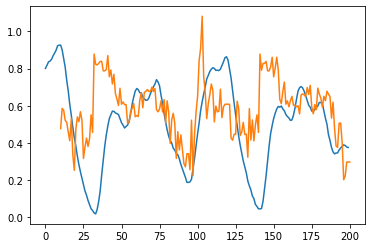

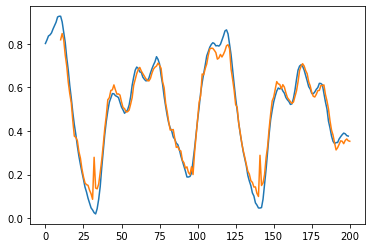

In [131]:
"""Read and Normalize the data"""
MG_data=pd.read_csv('../Data/MarkusThill-MGAB-60f6b17/1.csv').iloc[:,1].values
dmin, dmax= np.min(MG_data), np.max(MG_data)
normalized_MG=(MG_data - dmin) / (dmax - dmin)
noise = np.random.normal(0, 0.00, MG_data.shape)
normalized_MG=normalized_MG+noise

"create a test network and encoders"
n_neurons, synapse_density, n_input = 100, 0.1, 10
n_synapses = int((n_neurons**2)*synapse_density)
neurons = create_network(n_neurons, n_synapses, negative_weights = True, threshold_range = (0.35, 1), leak_range = (0.05, 0.25), weight_factor = 1)

"slice up MG into input, output pairs"
input_window_size,output_window_size = 10,1
MG_inputs_tr, MG_outputs_tr = generate_io_pairs(normalized_MG, input_window_size, output_window_size)

rs_trainer_abs=Reservior_DPE_training(neurons,n_input)
rs_trainer_abs.train_TS(MG_inputs_tr, MG_outputs_tr)

rs_trainer_rel=Reservior_DPE_training(neurons,n_input)
rs_trainer_rel.train_TS(MG_inputs_tr, MG_outputs_tr,relative=True)

# read new data for test
MG_data_te = pd.read_csv('../Data/MarkusThill-MGAB-60f6b17/3.csv').iloc[:,1].values
normalized_MG_te=(MG_data_te - dmin) / (dmax - dmin)
noise = np.random.normal(0, 0.00, MG_data_te.shape)
normalized_MG_te=normalized_MG_te+noise
MG_inputs_te, MG_outputs_te = generate_io_pairs(normalized_MG_te, input_window_size, output_window_size)
rs_trainer_abs.predict_timeseries(normalized_MG_te, MG_inputs_te)
rs_trainer_rel.predict_timeseries(normalized_MG_te, MG_inputs_te,relative=True)

In [ ]:
# """Read and Normalize the data"""
# MG_data=pd.read_csv('../Data/MarkusThill-MGAB-60f6b17/1.csv').iloc[:,1].values
# dmin, dmax= np.min(MG_data), np.max(MG_data)
# normalized_MG=(MG_data - dmin) / (dmax - dmin)
# noise = np.random.normal(0, 0.00, MG_data.shape)
# normalized_MG=normalized_MG+noise

# "create a test network and encoders"
# n_neurons, synapse_density, n_input = 100, 0.1, 10
# n_synapses = int((n_neurons**2)*synapse_density)
# neurons = create_network(n_neurons, n_synapses, negative_weights = True, threshold_range = (0.35, 1), leak_range = (0.05, 0.25), weight_factor = 1)

# "slice up MG into input, output pairs"
# input_window_size,output_window_size = 10,1
# MG_inputs_tr, MG_outputs_tr = generate_io_pairs(normalized_MG, input_window_size, output_window_size)
# "Training"
# print('training absolute')
# absolute_epoch_mses, absolute_dpe_weights, dpe_bias_absolute = train_TS(n_epochs, MG_inputs_tr, MG_outputs_tr, neurons, n_input)
# print('training relative')
# relative_epoch_mses, relative_dpe_weights, dpe_bias_relative = train_TS(n_epochs, MG_inputs_tr, MG_outputs_tr, neurons, n_input, relative=True)

# # read new data for test
# MG_data_te = pd.read_csv('../Data/MarkusThill-MGAB-60f6b17/3.csv').iloc[:,1].values
# normalized_MG_te=(MG_data_te - dmin) / (dmax - dmin)
# noise = np.random.normal(0, 0.02, MG_data_te.shape)
# normalized_MG_te=normalized_MG_te+noise
# MG_inputs_te, MG_outputs_te = generate_io_pairs(normalized_MG_te, input_window_size, output_window_size)
# test_timeseries(normalized_MG_te, MG_inputs_te, neurons, absolute_dpe_weights, bias = dpe_bias_absolute)
# test_timeseries(normalized_MG_te, MG_inputs_te, neurons, relative_dpe_weights, bias = dpe_bias_relative, relative=True)

# encoders = create_encoders(10)
# save_trained_network('absolute.json', neurons, encoders, absolute_dpe_weights, None, None, None, None, None)
# save_trained_network('relative.json', neurons, encoders, absolute_dpe_weights, None, None, None, None, None)

# # read new data for test
# MG_data_te = pd.read_csv('../Data/MarkusThill-MGAB-60f6b17/3.csv').iloc[:,1].values
# normalized_MG_te=(MG_data_te - dmin) / (dmax - dmin)
# noise = np.random.normal(0, 0.02, MG_data_te.shape)
# normalized_MG_te=normalized_MG_te+noise

# MG_inputs_te, MG_outputs_te = generate_io_pairs(normalized_MG_te, input_window_size, output_window_size)
# test_timeseries(normalized_MG_te, MG_inputs_te, neurons, absolute_dpe_weights, bias = dpe_bias_absolute)
# # MSE_absoluate=mse(MG_outputs_te[:len(yhat1)],yhat1)/len(yhat1)
# test_timeseries(normalized_MG_te, MG_inputs_te, neurons, relative_dpe_weights, bias = dpe_bias_relative, relative=True)
# # MSE_relative=mse(MG_outputs_te[:len(yhat2)],yhat2)/len(yhat2)
# encoders = create_encoders(10)
# save_trained_network('absolute.json', neurons, encoders, absolute_dpe_weights, None, None, None, None, None)
# save_trained_network('relative.json', neurons, encoders, absolute_dpe_weights, None, None, None, None, None)

In [173]:
dpe=np.squeeze(np.array(rs_trainer_abs.dpe_outputs))
gt=np.squeeze(rs_trainer_abs.TS_data[9:9+len(rs_trainer_abs.dpe_outputs)])

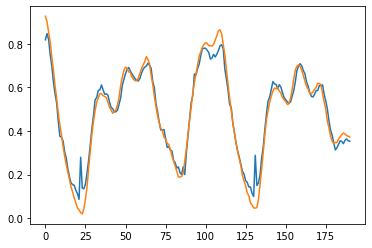

In [176]:
plt.plot(rs_trainer_rel.dpe_outputs)
plt.plot(rs_trainer_rel.TS_data[10:10+len(rs_trainer_rel.dpe_outputs)])